In [40]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import mean_shift, dbscan
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression

In [34]:
os.chdir('/home/pete/xandem/clustering-exploration/iris')
df = pd.read_csv('bezdekIris.data')
df.head(3)

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


# Pairwise relationships
We'll start by looking at pairwise relationships between features.

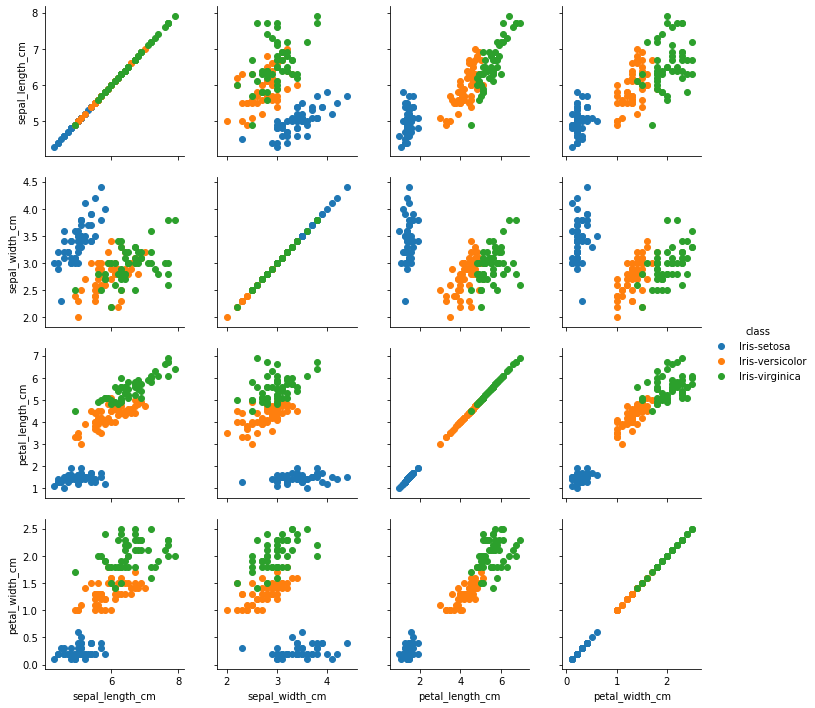

In [35]:
g = sns.PairGrid(df, hue='class');
g = g.map(plt.scatter);
g = g.add_legend()

## Observations
We start by looking at the upper diagonal plots. We'd like to see if there are any features that we could immediately use to discriminate between classes. Immediately, we see that we could perfectly classify `iris-setosa` by checking if the petal width < 0.9cm or if the petal length < 2.1 cm. Better yet, we could first fit the petal length and petal width data to a line and project all of the data onto that line. The plot below shows the OLS best fit line.

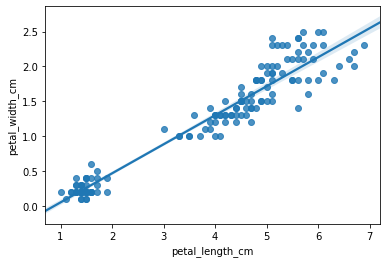

In [36]:
sns.regplot(x='petal_length_cm', y='petal_width_cm', data=df);

In [46]:
X = df['petal_length_cm'].values[np.newaxis].T
y = df['petal_width_cm'].values[np.newaxis].T
print(X.shape, y.shape)
reg = LinearRegression().fit(X, y)
print(reg.coef_.flatten(), reg.intercept_)

(150, 1) (150, 1)
[0.41575542] [-0.36307552]


In [0]:
feature_set = ['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']
X = df[feature_set]
transformer = RobustScaler().fit(X)

result = mean_shift(transformer.transform(X))
print(a)

for ii, c in enumerate(result[1]):
    if c == 0:
        print(df['class'].iloc[ii])

In [0]:
result = dbscan(transformer.transform(X))
print(a)

for ii, c in enumerate(result[1]):
    if c == 1:
        print(df['class'].iloc[ii])